## Material transistions with a directed graph

Geodynamic models often parameterise certain petrologic / geologic processes, either because solving the thermodynamic relationships is expensive, or the processes involve complex multiphysics - i.e generation and hydration of oceanic crust. 

This notebook demonstrates how a directed graph data-structure can be used to generate and apply material transitions. It incorporates the directed graph object from networkx package. Materials are given a unique integer index, and these indices become nodes in the graph. An edge between two nodes represents the availability or potential of a material transition - subject to certain conditions. Conditions are provided using the following function and syntax:
    
    DG.add_transition((index1,index2), uw.funcrtion, operator, value)
    
 
 an example is:
 
    DG.add_transition((2,1), coord[1], operator.gt, 0.9)
    
Here DG is the graph object, the tuple `(2,1)` generates an edge (i.e a transition)  between material 2 and 1. `coord[1]` is an underworld function, in this case the Y-coordinate of the particle, `operator.gt` is a function representation of the "greater than" operator. Finally, 0.9 is the the value on the RHS of the operator. 

In words this means, a particle of material 2 changes to material 3 whenever the Y-coordinate is greater that 0.9.

Multiple functions can be combined algebraically, which is a strength of Underworld. Hence phase relationships, which could be written like $C_1*T + C2*P < C_3$, could be easily incorporated into the graph. 

Once you have setup the graph with a number of materials and material transitions, you can apply the information to the swarm in two ways. Either you can loop through every particle and apply the graph information (slow), or you can write out a list of conditions which can then be input to Underworld's fn.branching.conditional() function:

    DG.build_condition_list(materialVariable)
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(swarm)
    

The MatGraph class from slippy2 is reproduced below, followed by a few examples.

class MatGraph(DiGraph): 

    def __init__(self):
        DiGraph.__init__(self) #Call the parent class init function
        self.number_changed = 1
        self.condition_list = []


    def add_transition(self, nodes, function, FnOperator, value, combineby = 'and'):
        """
        Function that allows you to easily add material transitions in Underworld simulations.
        This function creates graph 'nodes', representing the two materials.
        It also provided a simple way of decribing the rules determining the transision process

        Parameters
        ----------
        nodes : Tuple
            Representing the material Indexes of materials which a transition is likely to occur, e.g crust to eclogite.
        function: underworld.function._function.Function
            (could also be a constant)
        nOperator: operator
            operators must be provided in function form through the operator package, eg. operator.gt(1., 2.)
        value: float
            the value will be compared to the providided function, given the provided operator
        value: string
            'and' or 'or', defaults to 'and'. If multiple rules are provided for a single edge in the graph (representing the material transition)
            then they be applied in the sense of any ('or'), or all ('and')
        """
        firstEdge = True
        try:
            self[nodes[0]][nodes[1]] #see if the node exists
            #get names of previous condition dict:
            prevdname = self[nodes[0]][nodes[1]].keys()[0]
            firstEdge = False
        except:
            self.add_node(nodes[0])
            self.add_node(nodes[1])
            self.add_edges_from([nodes])
        #create a random name for dictionary (we do this so we can store multiple conditions on an edge.)
        dname = uuid.uuid4()
        self[nodes[0]][nodes[1]][dname] = {}
        self[nodes[0]][nodes[1]][dname]['function'] = function
        self[nodes[0]][nodes[1]][dname]['operator'] =  FnOperator
        self[nodes[0]][nodes[1]][dname]['value'] =  value
        self[nodes[0]][nodes[1]][dname]['combineby'] = 'and'
        if combineby == 'or':
            self[nodes[0]][nodes[1]][dname]['combineby'] =  'or'
        if not firstEdge:
            assert self[nodes[0]][nodes[1]][dname]['combineby'] == self[nodes[0]][nodes[1]][prevdname]['combineby'], "if the graph has multiple conditions on an edge, provided 'combineby' string must be identical to avoid ambiguity."
    def walk_update(self, swarm, materialVariable):
        """
        A function that allows you to update an underworld material swarm, given the directed graph (and rules) describing those transitions

        Parameters
        ----------
        swarm: underworld.swarm._swarm.Swarm
        materialVariable: underworld.swarm._swarmvariable.SwarmVariable

        Notes
        ----------
        A better way of doing this is the future would be to link the graph and conditions directly to the underworld fn.branching.conditional()
        This would amount to writing the graph conditions directly to a condition list.
        """
        self.number_changed = 0
        #Loop through particles
        for particleID in range(swarm.particleCoordinates.data.shape[0]):
            edgeFound = False
            partCoords = [swarm.particleCoordinates.data[particleID][0],swarm.particleCoordinates.data[particleID][1]]
            node = materialVariable.data[particleID][0] #each Mat is represented by a node in the graph
            #Loop through egdes
            for otherNode in self[node].keys(): #Now loop through connected nodes (graph edges)
                if edgeFound:
                    break
                #Loop through conditions on each edge
                for cond in self[node][otherNode].keys(): #Loop though conditions governing material transformation
                    if self[node][otherNode][cond]['operator'](self[node][otherNode][cond]['function'].evaluate(partCoords)[0][0], self[node][otherNode][cond]['value']):
                        edgeFound = otherNode
                        if self[node][otherNode][cond]['combineby'] == 'or':
                            break
                    else:
                        edgeFound = False
                        if self[node][otherNode][cond]['combineby'] == 'and':
                            break

            if edgeFound:
                materialVariable.data[particleID] = edgeFound
                self.number_changed += 1 #Utilising that the True + n = 1 + n 
                
    def build_condition_list(self, materialVariable):
        self.condition_list = [] #empty the condition list
        dm = 0.1
        for node in self.nodes():
            for otherNode in self[node].keys():
                checkFrom = ((materialVariable < (node+dm)) and (materialVariable > (node-dm)))
                print type(checkFrom)
                condIt = 0
                for cond in self[node][otherNode].keys():                   
                    op = self[node][otherNode][cond]['operator']
                    fun = self[node][otherNode][cond]['function']
                    val = self[node][otherNode][cond]['value']
                    condExp = op(fun, val)
                    if condIt == 0:
                        totCond = condExp
                    else:
                        if self[node][otherNode].values()[0]['combineby'] == 'or':
                            totCond = operator.or_(totCond, condExp)
                        else:
                            totCond = operator.and_(totCond, condExp)
                    condIt += 1
                #combCond = operator.and_(totCond, checkFrom)
                combCond = checkFrom
                self.condition_list.append(((combCond), otherNode))
        self.condition_list.append((True ,          materialVariable)) #if no conditions are true, return current matId

In [113]:
from networkx import DiGraph
import numpy as np
from easydict import EasyDict as edict
import operator
import uuid
import networkx as nx
import underworld as uw
from underworld import function as fn
from underworld import meshvariable as meshvariable
import glucifer

from slippy2 import material_graph

# Setup a simple domain and swarm

In [114]:
minX  = -2.0
maxX  =  2.0
minXv = -1.0
maxXv =  1.0

resX = 128
resY = 32

elementType="Q1/DQ0"  # This is enough for a test but not to use the code in anger

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, 1.),
                                 periodic    = [False, False]  ) 



velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.


In [115]:
swarm  = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=15 )
swarm.populate_using_layout( layout=swarmLayout )

materialVariable = swarm.add_variable( dataType="int", count=1 )


In [116]:
coord = fn.input()

In [117]:
# Initialise the 'materialVariable' data to represent different materials. 
materialV = 1 # viscoplastic
materialA = 0 # accommodation layer a.k.a. Sticky Air
materialU = 2 # Under layer
materialT = 3



In [119]:
#DG.condition_list

In [120]:
materialVariable.data[:] = materialA


In [121]:
sphereRadius = 0.1
sphereCentre = (0., 0.5)
distFn = coord - sphereCentre
offsetFn =  fn.math.dot( distFn, distFn)

## Update swarm with walk 

In [122]:
DG = material_graph.MatGraph()

DG.add_nodes_from([materialV, materialA, materialU])

In [123]:
#Here we add some nodes - edges - conditions to the graph
#DG.add_transition((0,1), coord[1], operator.gt, 0.5)
DG.add_transition((2,1), coord[1], operator.gt, 0.9)
DG.add_transition((0,2), coord[1], operator.lt, 0.1, combineby='or')
DG.add_transition((0,2), offsetFn, operator.lt, sphereRadius**2, combineby='or')
DG.add_transition((2,0), offsetFn, operator.gt, sphereRadius**2)


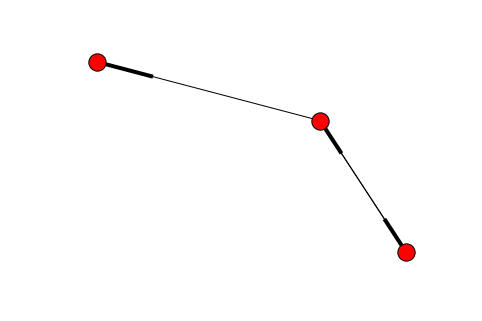

In [124]:
%matplotlib inline
nx.draw(DG,pos=nx.spring_layout(DG))

In [125]:
#Take  a look at the dictionary created by the .add_transition method


In [126]:
DG.number_changed

1

In [127]:
%%time
#No we can walk ths swarm and update particles based on those conditions
#At the moment we do this until there are no longer any changes to be made - there are faster alternatives though
while DG.number_changed != 0:
    DG.walk_update(swarm, materialVariable)

CPU times: user 12.9 s, sys: 130 ms, total: 13 s
Wall time: 13 s


In [128]:
#swarm.particleCoordinates.data.shape[0]


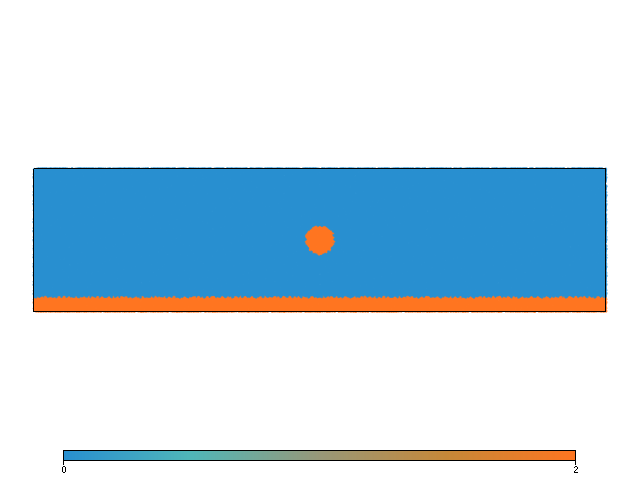

In [129]:
figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(swarm, materialVariable, pointSize=4))
figMat.show()

In [130]:
np.unique(materialVariable.data)

array([0, 2], dtype=int32)

## Update the swarm by integrating with fn.branching.conditional

In [131]:
materialVariable.data[:] = 0

In [132]:
DG.build_condition_list(materialVariable)


In [133]:
1-0.5, 1+0.5

(0.5, 1.5)

In [134]:
#%%time
#checkFrom = [(materialVariable > (node-dm)) and (materialVariable < (2+dm))]

#conditions = [(       (materialVariable < (2+0.5)) and (materialVariable > (2-0.5)), 2),
#           (       True ,           0) ]

materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(swarm)


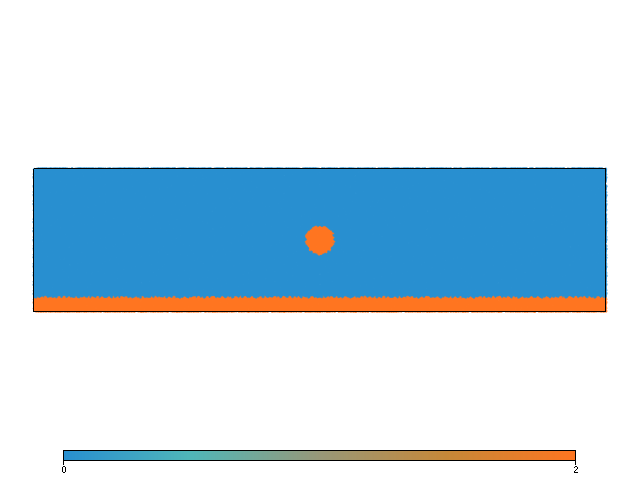

In [135]:
figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(swarm, materialVariable, pointSize=4))
figMat.show()